TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ENHANCED HYBRID DEEP LEARNING ENSEMBLE
Credit Card Fraud Detection

[STEP 1] Loading and preprocessing data...
Loading European Credit Card Fraud Detection dataset...
Please download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
Upload the 'creditcard.csv' file to Colab

Please upload creditcard.csv:


Saving creditcard.csv to creditcard (1).csv

Dataset shape: (284807, 31)
Fraud ratio: 0.17%
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Training set: (227845, 30), Test set: (56962, 30)
Training fraud ratio: 0.17%
Test fraud ratio: 0.17%

Applying SMOTE to balance training data...
After SMOTE - Training set: (454902, 30)
Fraud ratio after SMOTE: 50.00%

[STEP 2] Training baseline models...

TRAINING BASELINE MODELS

[1/2] Training Logistic Regression...

EVALUATION RESULTS: Logistic Regression

Recall (Sensitivity): 0.9184
Specificity:          0.9756
Precision:            0.0608
F1-Score:             0.1141
AUC-ROC:              0.9721

Confusion Matrix:
TN:  55474  |  FP:   1390
FN:      8  |  TP:     90

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro 

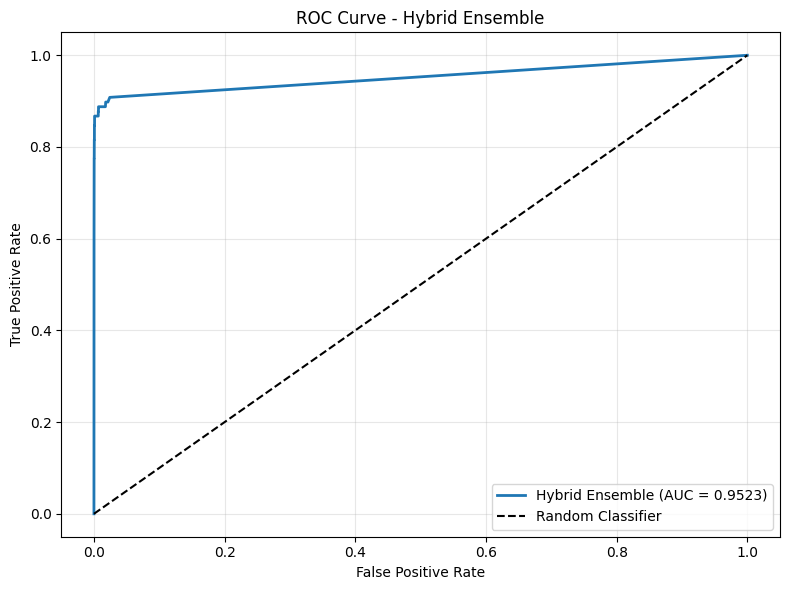

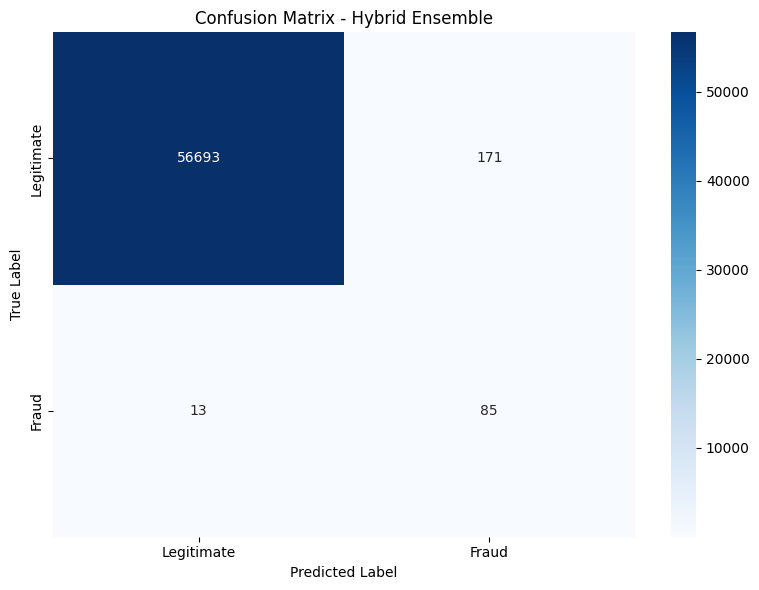

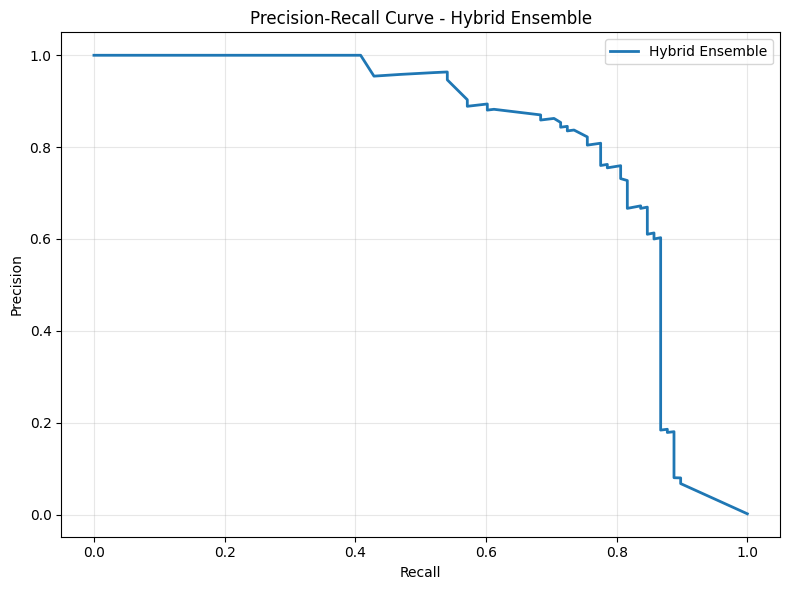


MODEL COMPARISON SUMMARY

               Model   Recall  Specificity  Precision  F1-Score  AUC-ROC
Logistic Regression 0.918367     0.975556   0.060811  0.114068 0.972063
      Random Forest 0.744898     0.999947   0.960526  0.839080 0.952909
    Hybrid Ensemble 0.867347     0.996993   0.332031  0.480226 0.952314


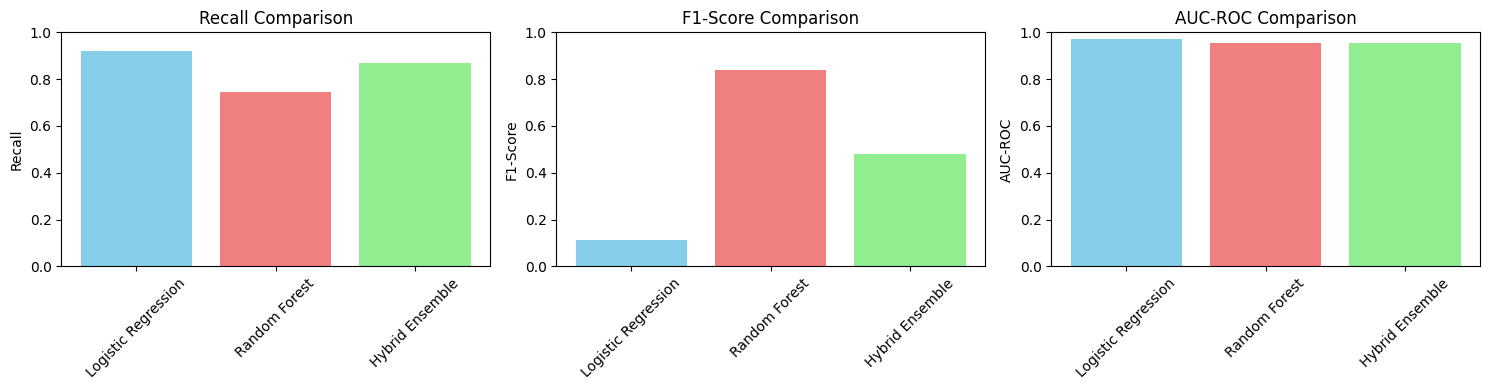


EXECUTION COMPLETED SUCCESSFULLY!

Saving models...
✓ Models saved successfully!


In [ ]:
"""
Enhanced Hybrid Deep Learning Ensemble for Credit Card Fraud Detection
Authors: Thabiso Msimango, Lungisani Khanyile
University of Pretoria - COS801 Deep Learning

This implementation combines CNN, LSTM, and Transformer architectures
with XGBoost meta-learner for credit card fraud detection.
"""

# ============================================================================
# 1. INSTALLATION AND IMPORTS
# ============================================================================

!pip install -q imbalanced-learn xgboost tensorflow scikit-learn pandas numpy matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, recall_score, precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ============================================================================
# 2. DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_preprocess_data(dataset_name='european'):
    """
    Load and preprocess credit card fraud datasets

    Parameters:
    - dataset_name: 'european' or 'taiwan'
    """
    if dataset_name == 'european':
        # Download European Credit Card Fraud Detection dataset
        print("Loading European Credit Card Fraud Detection dataset...")
        print("Please download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
        print("Upload the 'creditcard.csv' file to Colab")

        from google.colab import files
        print("\nPlease upload creditcard.csv:")
        uploaded = files.upload()

        df = pd.read_csv('creditcard.csv')

    elif dataset_name == 'taiwan':
        # Download Taiwan Credit Card dataset
        print("Loading Taiwan Credit Card dataset...")
        print("Please download from: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients")
        print("Upload the dataset file to Colab")

        from google.colab import files
        print("\nPlease upload the Taiwan credit card dataset:")
        uploaded = files.upload()

        # Adjust filename as needed
        df = pd.read_excel(list(uploaded.keys())[0], header=1)
        df = df.rename(columns={'default payment next month': 'Class'})

    print(f"\nDataset shape: {df.shape}")
    print(f"Fraud ratio: {df['Class'].mean()*100:.2f}%")
    print(f"Class distribution:\n{df['Class'].value_counts()}")

    return df

def create_sequences(X, y, sequence_length=10):
    """
    Create sequences for temporal models (LSTM/Transformer)
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - sequence_length + 1):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length-1])

    return np.array(X_seq), np.array(y_seq)

def preprocess_dataset(df, use_sequences=True, sequence_length=10):
    """
    Comprehensive preprocessing pipeline
    """
    # Separate features and target
    if 'Time' in df.columns:
        X = df.drop(['Class'], axis=1)
    else:
        X = df.drop(['Class'], axis=1)
    y = df['Class'].values

    # Normalize features
    scaler = StandardScaler()

    # Handle Amount column if present
    if 'Amount' in X.columns:
        X['Amount'] = scaler.fit_transform(X[['Amount']])

    # Normalize all features
    feature_names = X.columns
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")
    print(f"Training fraud ratio: {y_train.mean()*100:.2f}%")
    print(f"Test fraud ratio: {y_test.mean()*100:.2f}%")

    return X_train, X_test, y_train, y_test, feature_names

# ============================================================================
# 3. BASE LEARNER MODELS
# ============================================================================

class CNNModel:
    """
    CNN for spatial/local pattern extraction
    """
    def __init__(self, input_shape, filters=[64, 32, 16], dropout_rate=0.3):
        self.input_shape = input_shape
        self.filters = filters
        self.dropout_rate = dropout_rate
        self.model = None

    def build(self):
        """Build CNN architecture"""
        inputs = layers.Input(shape=self.input_shape)

        # Reshape for 1D convolution
        x = layers.Reshape((self.input_shape[0], 1))(inputs)

        # Convolutional blocks
        for f in self.filters:
            x = layers.Conv1D(f, kernel_size=3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling1D(pool_size=2)(x)
            x = layers.Dropout(self.dropout_rate)(x)

        # Global pooling and dense layers
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        self.model = models.Model(inputs=inputs, outputs=outputs, name='CNN')
        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with focal loss"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
        """Train the CNN model"""
        early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=10,
                                             mode='max', restore_best_weights=True)
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                patience=5, min_lr=1e-7)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            class_weight={0: 1, 1: 10},  # Handle imbalance
            verbose=1
        )
        return history

class LSTMModel:
    """
    LSTM for temporal pattern extraction
    """
    def __init__(self, input_shape, lstm_units=[64, 32], dropout_rate=0.3):
        self.input_shape = input_shape
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = None

    def build(self):
        """Build LSTM architecture"""
        inputs = layers.Input(shape=self.input_shape)

        # Reshape for sequence processing
        x = layers.Reshape((self.input_shape[0], 1))(inputs)

        # LSTM layers
        for i, units in enumerate(self.lstm_units):
            return_sequences = (i < len(self.lstm_units) - 1)
            x = layers.LSTM(units, return_sequences=return_sequences,
                          dropout=self.dropout_rate)(x)
            x = layers.BatchNormalization()(x)

        # Dense layers
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        self.model = models.Model(inputs=inputs, outputs=outputs, name='LSTM')
        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
        """Train the LSTM model"""
        early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=10,
                                             mode='max', restore_best_weights=True)
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                patience=5, min_lr=1e-7)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            class_weight={0: 1, 1: 10},
            verbose=1
        )
        return history

class TransformerModel:
    """
    Transformer for long-range dependencies with self-attention
    """
    def __init__(self, input_shape, num_heads=4, ff_dim=128, num_blocks=2, dropout_rate=0.3):
        self.input_shape = input_shape
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_blocks = num_blocks
        self.dropout_rate = dropout_rate
        self.model = None

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0.3):
        """Transformer encoder block"""
        # Multi-head attention
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        # Feed-forward network
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def build(self):
        """Build Transformer architecture"""
        inputs = layers.Input(shape=self.input_shape)

        # Reshape and project to embedding dimension
        x = layers.Reshape((self.input_shape[0], 1))(inputs)
        x = layers.Dense(64)(x)

        # Transformer blocks
        head_size = 64 // self.num_heads
        for _ in range(self.num_blocks):
            x = self.transformer_encoder(x, head_size, self.num_heads,
                                        self.ff_dim, self.dropout_rate)

        # Global pooling and classification
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        self.model = models.Model(inputs=inputs, outputs=outputs, name='Transformer')
        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
        """Train the Transformer model"""
        early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=10,
                                             mode='max', restore_best_weights=True)
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                patience=5, min_lr=1e-7)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            class_weight={0: 1, 1: 10},
            verbose=1
        )
        return history

# ============================================================================
# 4. ENSEMBLE WITH XGBOOST META-LEARNER
# ============================================================================

class HybridEnsemble:
    """
    Hybrid ensemble combining CNN, LSTM, Transformer with XGBoost meta-learner
    """
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.cnn = None
        self.lstm = None
        self.transformer = None
        self.meta_learner = None
        self.scaler = StandardScaler()

    def build_base_learners(self):
        """Build all base learner models"""
        print("Building base learners...")

        # CNN
        self.cnn = CNNModel(self.input_shape)
        self.cnn.build()
        self.cnn.compile_model()
        print("✓ CNN built")

        # LSTM
        self.lstm = LSTMModel(self.input_shape)
        self.lstm.build()
        self.lstm.compile_model()
        print("✓ LSTM built")

        # Transformer
        self.transformer = TransformerModel(self.input_shape)
        self.transformer.build()
        self.transformer.compile_model()
        print("✓ Transformer built")

    def train_base_learners(self, X_train, y_train, X_val, y_val,
                           epochs=50, batch_size=128):
        """Train all base learners"""
        print("\n" + "="*70)
        print("TRAINING BASE LEARNERS")
        print("="*70)

        # Train CNN
        print("\n[1/3] Training CNN...")
        self.cnn.train(X_train, y_train, X_val, y_val, epochs, batch_size)

        # Train LSTM
        print("\n[2/3] Training LSTM...")
        self.lstm.train(X_train, y_train, X_val, y_val, epochs, batch_size)

        # Train Transformer
        print("\n[3/3] Training Transformer...")
        self.transformer.train(X_train, y_train, X_val, y_val, epochs, batch_size)

        print("\n✓ All base learners trained successfully!")

    def get_base_predictions(self, X):
        """Get predictions from all base learners"""
        cnn_pred = self.cnn.model.predict(X, verbose=0).flatten()
        lstm_pred = self.lstm.model.predict(X, verbose=0).flatten()
        transformer_pred = self.transformer.model.predict(X, verbose=0).flatten()

        # Stack predictions as meta-features
        meta_features = np.column_stack([cnn_pred, lstm_pred, transformer_pred])
        return meta_features

    def train_meta_learner(self, X_train, y_train, X_val, y_val):
        """Train XGBoost meta-learner on base learner predictions"""
        print("\n" + "="*70)
        print("TRAINING META-LEARNER (XGBoost)")
        print("="*70)

        # Get base learner predictions
        print("Getting base learner predictions...")
        meta_train = self.get_base_predictions(X_train)
        meta_val = self.get_base_predictions(X_val)

        # Calculate scale_pos_weight for imbalanced data
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

        # Train XGBoost
        self.meta_learner = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='auc',
            early_stopping_rounds=10
        )

        self.meta_learner.fit(
            meta_train, y_train,
            eval_set=[(meta_val, y_val)],
            verbose=True
        )

        print("\n✓ Meta-learner trained successfully!")

    def predict(self, X):
        """Make final predictions using the ensemble"""
        meta_features = self.get_base_predictions(X)
        return self.meta_learner.predict(meta_features)

    def predict_proba(self, X):
        """Get prediction probabilities"""
        meta_features = self.get_base_predictions(X)
        return self.meta_learner.predict_proba(meta_features)

# ============================================================================
# 5. EVALUATION METRICS AND VISUALIZATION
# ============================================================================

def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Comprehensive evaluation with all required metrics
    """
    print("\n" + "="*70)
    print(f"EVALUATION RESULTS: {model_name}")
    print("="*70)

    # Calculate metrics
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_proba[:, 1])

    # Confusion matrix for specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print(f"\nRecall (Sensitivity): {recall:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"F1-Score:             {f1:.4f}")
    print(f"AUC-ROC:              {auc_roc:.4f}")

    print(f"\nConfusion Matrix:")
    print(f"TN: {tn:6d}  |  FP: {fp:6d}")
    print(f"FN: {fn:6d}  |  TP: {tp:6d}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                               target_names=['Legitimate', 'Fraud']))

    return {
        'recall': recall,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm
    }

def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name="Model"):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_proba, model_name="Model"):
    """Plot Precision-Recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 6. BASELINE MODELS
# ============================================================================

def train_baseline_models(X_train, y_train, X_test, y_test):
    """
    Train baseline models for comparison
    """
    print("\n" + "="*70)
    print("TRAINING BASELINE MODELS")
    print("="*70)

    results = {}

    # Logistic Regression
    print("\n[1/2] Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_proba = lr.predict_proba(X_test)
    results['Logistic Regression'] = evaluate_model(y_test, lr_pred, lr_proba,
                                                     "Logistic Regression")

    # Random Forest
    print("\n[2/2] Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42,
                                class_weight='balanced', n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_proba = rf.predict_proba(X_test)
    results['Random Forest'] = evaluate_model(y_test, rf_pred, rf_proba,
                                              "Random Forest")

    return results

# ============================================================================
# 7. MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """
    Main execution pipeline
    """
    print("="*70)
    print("ENHANCED HYBRID DEEP LEARNING ENSEMBLE")
    print("Credit Card Fraud Detection")
    print("="*70)

    # Step 1: Load and preprocess data
    print("\n[STEP 1] Loading and preprocessing data...")
    df = load_and_preprocess_data(dataset_name='european')
    X_train, X_test, y_train, y_test, feature_names = preprocess_dataset(df)

    # Apply SMOTE to training data
    print("\nApplying SMOTE to balance training data...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE - Training set: {X_train_balanced.shape}")
    print(f"Fraud ratio after SMOTE: {y_train_balanced.mean()*100:.2f}%")

    # Create validation set
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
    )

    # Step 2: Train baseline models
    print("\n[STEP 2] Training baseline models...")
    baseline_results = train_baseline_models(X_train, y_train, X_test, y_test)

    # Step 3: Build and train ensemble
    print("\n[STEP 3] Building hybrid ensemble...")
    input_shape = (X_train_final.shape[1],)
    ensemble = HybridEnsemble(input_shape)
    ensemble.build_base_learners()

    # Train base learners
    ensemble.train_base_learners(X_train_final, y_train_final, X_val, y_val,
                                epochs=30, batch_size=256)

    # Train meta-learner
    ensemble.train_meta_learner(X_train_final, y_train_final, X_val, y_val)

    # Step 4: Evaluate ensemble
    print("\n[STEP 4] Evaluating hybrid ensemble...")
    ensemble_pred = ensemble.predict(X_test)
    ensemble_proba = ensemble.predict_proba(X_test)
    ensemble_results = evaluate_model(y_test, ensemble_pred, ensemble_proba,
                                     "Hybrid Ensemble")

    # Step 5: Visualizations
    print("\n[STEP 5] Generating visualizations...")
    plot_roc_curve(y_test, ensemble_proba, "Hybrid Ensemble")
    plot_confusion_matrix(ensemble_results['confusion_matrix'], "Hybrid Ensemble")
    plot_precision_recall_curve(y_test, ensemble_proba, "Hybrid Ensemble")

    # Step 6: Compare all models
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)

    comparison_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'Hybrid Ensemble'],
        'Recall': [baseline_results['Logistic Regression']['recall'],
                   baseline_results['Random Forest']['recall'],
                   ensemble_results['recall']],
        'Specificity': [baseline_results['Logistic Regression']['specificity'],
                       baseline_results['Random Forest']['specificity'],
                       ensemble_results['specificity']],
        'Precision': [baseline_results['Logistic Regression']['precision'],
                     baseline_results['Random Forest']['precision'],
                     ensemble_results['precision']],
        'F1-Score': [baseline_results['Logistic Regression']['f1'],
                    baseline_results['Random Forest']['f1'],
                    ensemble_results['f1']],
        'AUC-ROC': [baseline_results['Logistic Regression']['auc_roc'],
                   baseline_results['Random Forest']['auc_roc'],
                   ensemble_results['auc_roc']]
    })

    print("\n", comparison_df.to_string(index=False))

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    metrics = ['Recall', 'F1-Score', 'AUC-ROC']

    for idx, metric in enumerate(metrics):
        axes[idx].bar(comparison_df['Model'], comparison_df[metric],
                     color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[idx].set_ylabel(metric)
        axes[idx].set_title(f'{metric} Comparison')
        axes[idx].set_ylim([0, 1])
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*70)

    return ensemble, comparison_df

# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    ensemble_model, results_df = main()

    # Save models (optional)
    print("\nSaving models...")
    ensemble_model.cnn.model.save('cnn_model.h5')
    ensemble_model.lstm.model.save('lstm_model.h5')
    ensemble_model.transformer.model.save('transformer_model.h5')
    ensemble_model.meta_learner.save_model('xgboost_meta_learner.json')
    print("✓ Models saved successfully!")